# BCQ with Pyro Inference

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

In [2]:
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, JitTrace_ELBO
import pyro.optim as poptim

In [3]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import pickle
import gc
import json
import h5py

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

# == recnn ==
import sys
sys.path.append("../../")
import recnn

cuda = torch.device('cuda')

# ---
frame_size = 10
batch_size = 25
# --- 

tqdm.pandas()

In [4]:
# https://drive.google.com/open?id=1kTyu05ZmtP2MA33J5hWdX8OyUYEDW4iI
movie_embeddings_key_dict = pickle.load(open('../../data/infos_pca128.pytorch', 'rb'))
movies_embeddings_tensor, \
key_to_id, id_to_key = recnn.data.make_items_tensor(movie_embeddings_key_dict)
# download ml20m dataset yourself
ratings = pd.read_csv('../../data/ml-20m/ratings.csv')
user_dict, users = recnn.data.prepare_dataset(ratings, key_to_id, frame_size)
del ratings
gc.collect()
clear_output(True)
clear_output(True)
print('Done!')

Done!


In [5]:
from jupyterthemes import jtplot
jtplot.style(theme='monokai')

def run_tests():
    test_batch = next(iter(test_dataloader))
    losses = bcq_update(test_batch, params, learn=False, step=step)
    return losses

def soft_update(net, target_net, soft_tau=1e-2):
    for target_param, param in zip(target_net.parameters(), net.parameters()):
            target_param.data.copy_(
                target_param.data * (1.0 - soft_tau) + param.data * soft_tau
            )

In [6]:
class Encoder(nn.Module):
    def __init__(self, input_dim, action_dim, latent_dim):
        super(Encoder, self).__init__()
        self.e1 = nn.Linear(input_dim + action_dim, 750)
        self.e2 = nn.Linear(750, 750)

        self.mean = nn.Linear(750, latent_dim)
        self.log_std = nn.Linear(750, latent_dim)
    
    def forward(self, state, action):
        z = F.relu(self.e1(torch.cat([state, action], 1)))
        z = F.relu(self.e2(z))
        mean = self.mean(z)
        log_std = self.log_std(z).clamp(-4, 4)
        std = torch.exp(log_std)
        return mean, std
    
class Decoder(nn.Module):
    def __init__(self, input_dim, action_dim, latent_dim):
        super(Decoder, self).__init__()
        self.d1 = nn.Linear(input_dim + latent_dim, 750)
        self.d2 = nn.Linear(750, 750)
        self.d3 = nn.Linear(750, action_dim)
        
    def forward(self, state, z):
        z = torch.cat([state, z], 1)
        z =  F.relu(self.d1(z))
        z =  F.relu(self.d2(z))
        z =  F.relu(self.d3(z))
        return z


class Generator(nn.Module):
    def __init__(self, input_dim, action_dim, latent_dim):
        super(Generator, self).__init__()
        self.encoder = Encoder(input_dim, action_dim, latent_dim)
        self.decoder = Decoder(input_dim, action_dim, latent_dim)
        self.latent_dim = latent_dim
        self.normal = torch.distributions.Normal(0, 1)
    
    def model(self, state, action):
        pyro.module("decoder", self.decoder)
        batch_size = state.size(0)
        with pyro.plate("data", batch_size):
            # setup hyperparameters for prior p(z)
            z_loc = torch.zeros(torch.Size((batch_size, self.latent_dim))).to(cuda)
            z_scale = torch.ones(torch.Size((batch_size, self.latent_dim))).to(cuda)
            # sample from prior (value will be sampled by guide when computing the ELBO)
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1)).to(cuda)
            # decode the latent code z
            decoded = self.decoder.forward(state, z)
            # score against actual images
            pyro.sample("obs", dist.Bernoulli(decoded).to_event(1), obs=action)

    def guide(self, state, action):
        pyro.module("encoder", self.encoder)
        batch_size = state.size(0)
        with pyro.plate("data", batch_size):
            # use the encoder to get the parameters used to define q(z|x)
            z_loc, z_scale = self.encoder.forward(state, action)
            # sample the latent code z
            pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))
            
    def decode(self, state, z=None):
        if z is None:
            z = self.normal.sample([state.size(0), self.latent_dim])
            z = z.clamp(-0.9, 0.9).to(cuda)
            
        return self.decoder(state, z)
    
    def forward(self, state, action):
        # encode image x
        z_loc, z_scale = self.encoder(state, action)
        # sample in latent space
        z = dist.Normal(z_loc, z_scale).sample()
        # decode the image (note we don't sample in image space)
        action = self.decoder(z, state)
        return action

In [7]:
# P.S. This is not a usual Actor.
# It is a peturbative network that takes an input from the Generator
# And adjusts (perturbates) it to look like normal action
# P.S. Yep, this is also a reference, check out his soundcloud:
# soundcloud.com/perturbator
class Perturbator(nn.Module):
    def __init__(self, input_dim, action_dim, hidden_size, init_w=3e-1):
        super(Perturbator, self).__init__()
        
        self.drop_layer = nn.Dropout(p=0.5)
        
        self.linear1 = nn.Linear(input_dim + action_dim, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, action_dim)
        
        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state, action):
        a = torch.cat([state, action], 1)
        a = F.relu(self.linear1(a))
        a = self.drop_layer(a)
        a = F.relu(self.linear2(a))
        a = self.drop_layer(a)
        a = self.linear3(a) 
        return a + action

In [ ]:
def bcq_update(batch, params, learn=True, step=-1):
    
    batch = [i.to(cuda) for i in batch]
    state, action, reward, next_state, done = batch
    reward     = reward.unsqueeze(1)
    done       = done.unsqueeze(1)
    batch_size = done.size(0)
    
    # --------------------------------------------------------#
    # Variational Auto-Encoder Learning
    recon = generator_net(state, action)
    if not learn:
        generator_loss = generator_optimizer.evaluate_loss(state, action)
        debugger.log_object('recon test', recon)
        writer.add_figure('reconstructed',
                          recnn.plot.pairwise_distances_fig(recon[:50]), step)
        
    if learn:
        generator_loss = generator_optimizer.step(state, action)
        debugger.log_object('recon', recon)
        
    # --------------------------------------------------------#
    # Value Learning
    with torch.no_grad():
        # p.s. repeat_interleave was added in torch 1.1
        # if an error pops up, run 'conda update pytorch'
        state_rep = torch.repeat_interleave(next_state, params['n_generator_samples'], 0)
        sampled_action = generator_net.decode(state_rep)
        perturbed_action = target_perturbator_net(state_rep, sampled_action)
        target_Q1 = target_value_net1(state_rep, perturbed_action)
        target_Q2 = target_value_net1(state_rep, perturbed_action)
        target_value = 0.75 * torch.min(target_Q1, target_Q2) # value soft update
        target_value+= 0.25 * torch.max(target_Q1, target_Q2) #
        target_value = target_value.view(batch_size, -1).max(1)[0].view(-1, 1)
        
        expected_value = reward + (1.0 - done) * params['gamma'] * target_value

    value = value_net1(state, action)
    value_loss = torch.pow(value - expected_value.detach(), 2).mean()
    debugger.log_error('value', value, test=(not learn))
    debugger.log_error('target_value ', target_value, test=(not learn))
    
    if learn:
        value_optimizer1.zero_grad()
        value_optimizer2.zero_grad()
        value_loss.backward()
        value_optimizer1.step()
        value_optimizer2.step()
    else:
        writer.add_histogram('value', value, step)
        writer.add_histogram('target value', target_value, step)
        writer.add_histogram('expected value', expected_value, step)
        writer.close()
    
    # --------------------------------------------------------#
    # Perturbator learning
    sampled_actions = generator_net.decode(state)
    perturbed_actions= perturbator_net(state, sampled_actions)
    perturbator_loss = -value_net1(state, perturbed_actions)
    if not learn:
        writer.add_histogram('perturbator_loss', perturbator_loss, step)
    perturbator_loss = perturbator_loss.mean()
    
    debugger.log_object('sampled_actions', sampled_actions, test=(not learn))
    debugger.log_object('perturbed_actions', perturbed_actions, test=(not learn))
    
    if learn:
        if step % params['perturbator_step']:
            perturbator_optimizer.zero_grad()
            perturbator_loss.backward()
            torch.nn.utils.clip_grad_norm_(perturbator_net.parameters(), -1, 1)
            perturbator_optimizer.step()
        
        soft_update(value_net1, target_value_net1, soft_tau=params['soft_tau'])
        soft_update(value_net2, target_value_net2, soft_tau=params['soft_tau'])
        soft_update(perturbator_net, target_perturbator_net, soft_tau=params['soft_tau'])
    else:
        writer.add_figure('sampled_actions',
            recnn.plot.pairwise_distances_fig(sampled_actions[:50]), step)
        writer.add_figure('perturbed_actions',
            recnn.plot.pairwise_distances_fig(perturbed_actions[:50]), step)
        
    # --------------------------------------------------------#

    losses = {'value': value_loss.item(),
              'perturbator': perturbator_loss.item(),
              'generator': generator_loss,
              'step': step}
    
    return losses

In [ ]:
# === BCQ settings ===
params = {
    # algorithm parameters
    'gamma'              : 0.99,
    'soft_tau'           : 0.001,
    'n_generator_samples': 10,
    'perturbator_step'   : 10,
    
    # learning rates
    'perturbator_lr' : 1e-5,
    'value_lr'       : 1e-5,
    'generator_lr'   : 1e-3,
}
# === end ===

In [ ]:
generator_net = Generator(1290, 128, 512).to(cuda)
value_net1  = recnn.models.Critic(1290, 128, 256, init_w=8e-1).to(cuda)
value_net2  = recnn.models.Critic(1290, 128, 256, init_w=8e-1).to(cuda)
perturbator_net = Perturbator(1290, 128, 256).to(cuda)

target_value_net1 = recnn.models.Critic(1290, 128, 256).to(cuda)
target_value_net2 = recnn.models.Critic(1290, 128, 256).to(cuda)
target_perturbator_net = Perturbator(1290, 128, 256).to(cuda)

target_perturbator_net.eval()
target_value_net1.eval()
target_value_net2.eval()

soft_update(value_net1, target_value_net1, soft_tau=1.0)
soft_update(value_net2, target_value_net2, soft_tau=1.0)
soft_update(perturbator_net, target_perturbator_net, soft_tau=1.0)


# optim.Adam can be replaced with RAdam
value_optimizer1 = recnn.optim.RAdam(value_net1.parameters(),
                              lr=params['value_lr'])
value_optimizer2 = recnn.optim.RAdam(value_net2.parameters(),
                              lr=params['perturbator_lr'])
perturbator_optimizer = recnn.optim.RAdam(perturbator_net.parameters(),
                              lr=params['value_lr'], weight_decay=1e-1)
generator_optimizer = SVI(generator_net.model, generator_net.guide,
                          poptim.Adam({"lr": params['generator_lr']}), loss=JitTrace_ELBO())
# I would advice you not to weight decay generator

layout = {
    'train': {'value': [], 'perturbator': [], 'generator': [], 'step': []},
    'test': {'value': [], 'perturbator': [], 'generator': [], 'step': []},
    }

writer = SummaryWriter(log_dir='../../runs')
debugger = recnn.Debugger(layout, run_tests, writer)
plotter = recnn.Plotter(debugger, [['generator'], ['value', 'perturbator']],)

In [ ]:
value_losses  = []
perturbator_losses = []
generator_losses    = []
test_losses   = [[], [], [], []]

step = 1
n_epochs = 100
batch_size = 25

epoch_bar = tqdm(total=n_epochs)

test_losses = [[], [], [], []]
train_users = users[:-5000]
test_users = users[-5000:]

def prepare_batch_wrapper(x):
    batch = recnn.data.prepare_batch_static_size(x, movies_embeddings_tensor,
                                                 frame_size=frame_size)
    return batch

train_user_dataset = recnn.data.UserDataset(train_users, user_dict)
test_user_dataset = recnn.data.UserDataset(test_users, user_dict)
train_dataloader = DataLoader(train_user_dataset, batch_size=batch_size,
                        shuffle=True, num_workers=1,collate_fn=prepare_batch_wrapper)
test_dataloader = DataLoader(test_user_dataset, batch_size=batch_size,
                        shuffle=True, num_workers=1,collate_fn=prepare_batch_wrapper)

step 370


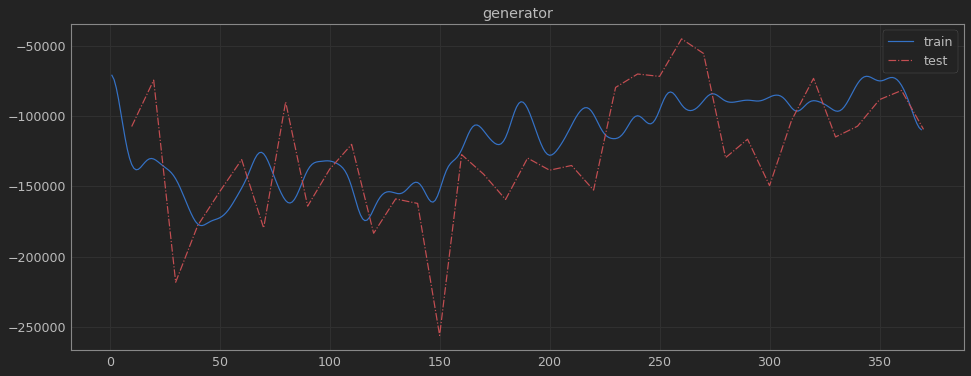

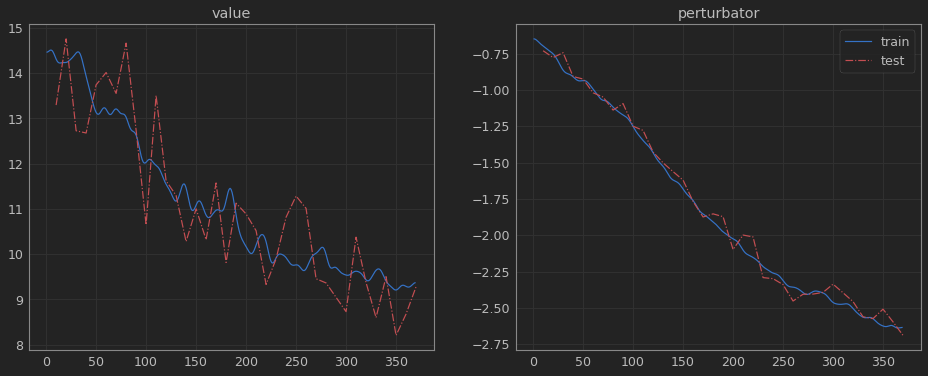

In [ ]:

# --- config ---
plot_every = 10
# --- end ---

for epoch in range(n_epochs):
    epoch_bar.update(1)
    for batch in tqdm(train_dataloader):
        loss = bcq_update(batch, params, step=step)
        debugger.log_losses(loss)
        step += 1
        debugger.log_step(step)
        if step % plot_every == 0:
            clear_output(True)
            print('step', step)
            debugger.test()
            plotter.plot_loss()